In [1]:
#NEW IDEA. PERHAPS FOR EACH FIGHT, WE LOOK AT THE CORRESPONDING POINT IN THE SPACE OF ALL FEATURES, AND THEN
#BUILD A MODEL WHERE THE TRAINING SET ONLY INVOLVES POINTS NEAR THAT POINT.
#THIS MIGHT BE MORE EFFECTIVE BECAUSE THE MOST RELEVANT FEATURES IS LIKELY TO DEPEND ON THE LOCATION
#IN THE PARAMETER SPACE.

In [2]:
#getting dependencies
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn' (disables SettingWithCopyWarning)

import numpy as npy
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import random
import sklearn
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
import itertools
#this imports all of the functions from the file functions.py
from functions import *

In [3]:
#importing csv fight data and saving as dataframes
ufc_fights_winner = pd.read_csv('ufc_fights.csv',low_memory=False)
ufc_fights_method = pd.read_csv('ufc_fights.csv',low_memory=False)
ufcfighterscrap =pd.read_csv('fighter_stats.csv',sep=',',low_memory=False)

In [4]:
for i in range(len(ufcfighterscrap['name'])):
    if ufcfighterscrap['name'][i]=='Xiaonan Yan':
        ufcfighterscrap['name'][i]='Yan Xiaonan'
        
for i in range(len(ufcfightscrap['fighter'])):
    if ufcfightscrap['fighter'][i]=='Xiaonan Yan':
        ufcfightscrap['fighter'][i]='Yan Xiaonan'
        
for i in range(len(ufcfightscrap['opponent'])):
    if ufcfightscrap['opponent'][i]=='Xiaonan Yan':
        ufcfightscrap['opponent'][i]='Yan Xiaonan'
    
#it gets saved as Joanne Wood for some reason
for i in range(len(ufc_fights['fighter'])):
    if ufc_fights['fighter'][i]=='Joanne Wood':
        ufc_fights['fighter'][i]='Joanne Calderwood'
    if ufc_fights['opponent'][i]=='Joanne Wood':
        ufc_fights['opponent'][i]='Joanne Calderwood'

In [5]:
#there are two lists of names which sometimes get scraped differently... this causes some problems which are being
#addressed in this cell. 

names_list = list(set((list(ufcfightscrap['fighter'])+list(ufcfightscrap['opponent']))))
names_list.sort()

names_list2 = list(set(ufcfighterscrap['name']))
names_list2.sort()

#Use the following two lines of code to examine names if necessary...

#for name in names_list:
    #print(name)
    
#for name in names_list2:
    #print(name)

In [6]:
#cleaning the methods column for winner prediction (counting split decisions as bullshit)
ufc_fights_winner['method'] = clean_method_for_winner_vect(ufc_fights_winner['method'])
ufc_fights_winner['method'].unique()

array(['DEC', 'KO/TKO', 'SUB', 'bullshit'], dtype=object)

In [7]:
#cleaning the methods column for method prediction (counting split decisions as decisions)
ufc_fights_method['method'] = clean_method_vect(ufc_fights_method['method'])
ufc_fights_method['method'].unique()

array(['DEC', 'KO/TKO', 'SUB', 'bullshit'], dtype=object)

In [8]:
#getting rid of rows with incomplete or useless data
#fights with outcome "Win" or "Loss" (no "Draw")
draw_mask=ufc_fights['result'] != 'D' 
#fights where the method of victory is TKO/SUB/DEC (no split decision or DQ or Overturned or anything else like that)
method_mask_winner=(ufc_fights_winner['method']!='bullshit')
method_mask_method=(ufc_fights_method['method']!='bullshit')
#fights where age is known
age_mask=(ufc_fights['fighter_age']!='unknown')&(ufc_fights['opponent_age']!='unknown')
#fights where height reach is known
height_mask=(ufc_fights['fighter_height']!='unknown')&(ufc_fights['opponent_height']!='unknown')
reach_mask=(ufc_fights['fighter_reach']!='unknown')&(ufc_fights['opponent_reach']!='unknown')
#fights where number of wins is known
wins_mask=(ufc_fights['fighter_wins'] != 'unknown' )& (ufc_fights['opponent_wins'] != 'unknown')
#fights where both fighters have strike statistics (gets rid of UFC debuts)
strikes_mask=(ufc_fights['fighter_inf_sig_strikes_attempts_avg'] != 0)&(ufc_fights['opponent_inf_sig_strikes_attempts_avg'] != 0)
#includes only the fights satisfying these conditions
ufc_fights_winner=ufc_fights_winner[draw_mask&method_mask_winner&age_mask&height_mask&reach_mask&wins_mask&strikes_mask]
ufc_fights_method=ufc_fights_method[draw_mask&method_mask_method&age_mask&height_mask&reach_mask&wins_mask&strikes_mask]

#listing all stats and making some new stats from them (differences often score higher in the learning models)
record_statistics=[u'fighter_wins', 
                   u'fighter_losses',
                   u'fighter_L5Y_wins',
                   u'fighter_L5Y_losses', 
                   u'fighter_L2Y_wins', 
                   u'fighter_L2Y_losses',
                    u'fighter_ko_wins',
                   u'fighter_ko_losses',
                   u'fighter_L5Y_ko_wins',
                   u'fighter_L5Y_ko_losses',
                   u'fighter_L2Y_ko_wins',
                    u'fighter_L2Y_ko_losses',
                   u'fighter_sub_wins',
                   u'fighter_sub_losses',
                   u'fighter_L5Y_sub_wins',
                    u'fighter_L5Y_sub_losses', 
                   u'fighter_L2Y_sub_wins', 
                   u'fighter_L2Y_sub_losses',
                   u'opponent_wins', 
                   u'opponent_losses',
                   u'opponent_L5Y_wins', 
                   u'opponent_L5Y_losses', 
                   u'opponent_L2Y_wins', 
                   u'opponent_L2Y_losses', 
                    u'opponent_ko_wins', 
                   u'opponent_ko_losses', 
                   u'opponent_L5Y_ko_wins', 
                   u'opponent_L5Y_ko_losses', 
                   u'opponent_L2Y_ko_wins',
                    u'opponent_L2Y_ko_losses', 
                   u'opponent_sub_wins', 
                   u'opponent_sub_losses',
                   u'opponent_L5Y_sub_wins', 
                    u'opponent_L5Y_sub_losses', 
                   u'opponent_L2Y_sub_wins', 
                   u'opponent_L2Y_sub_losses']

physical_stats=[ u'fighter_age',
                u'fighter_height',
                    u'fighter_reach',  
                u'opponent_age',  
                u'opponent_height',
                    u'opponent_reach']

#THERE MAY BE A PROBLEM IN AGE HEIGHT REACH TO DO WITH STRING VS FLOAT. MAKE SURE THESE ARE ALL THE CORRECT TYPE
#MAYBE WE ARE LOSING PREDICTABILITY HERE

#here is the list of all stats available (besides stance), does not include names or result
punch_statistics=[    u'fighter_inf_knockdowns_avg',
                    u'fighter_inf_pass_avg',
                    u'fighter_inf_reversals_avg',
                    u'fighter_inf_sub_attempts_avg',
                    u'fighter_inf_takedowns_landed_avg',
                    u'fighter_inf_takedowns_attempts_avg',
                    u'fighter_inf_sig_strikes_landed_avg',
                    u'fighter_inf_sig_strikes_attempts_avg',
                    u'fighter_inf_total_strikes_landed_avg',
                    u'fighter_inf_total_strikes_attempts_avg',
                    u'fighter_inf_head_strikes_landed_avg',
                    u'fighter_inf_head_strikes_attempts_avg',
                    u'fighter_inf_body_strikes_landed_avg',
                    u'fighter_inf_body_strikes_attempts_avg',
                    u'fighter_inf_leg_strikes_landed_avg',
                    u'fighter_inf_leg_strikes_attempts_avg',
                    u'fighter_inf_distance_strikes_landed_avg',
                    u'fighter_inf_distance_strikes_attempts_avg',
                    u'fighter_inf_clinch_strikes_landed_avg',
                    u'fighter_inf_clinch_strikes_attempts_avg',
                    u'fighter_inf_ground_strikes_landed_avg',
                    u'fighter_inf_ground_strikes_attempts_avg',
                
                    u'fighter_abs_knockdowns_avg',
                    u'fighter_abs_pass_avg',
                    u'fighter_abs_reversals_avg',
                    u'fighter_abs_sub_attempts_avg',
                    u'fighter_abs_takedowns_landed_avg',
                    u'fighter_abs_takedowns_attempts_avg',
                    u'fighter_abs_sig_strikes_landed_avg',
                    u'fighter_abs_sig_strikes_attempts_avg',
                    u'fighter_abs_total_strikes_landed_avg',
                    u'fighter_abs_total_strikes_attempts_avg',
                    u'fighter_abs_head_strikes_landed_avg',
                    u'fighter_abs_head_strikes_attempts_avg',
                    u'fighter_abs_body_strikes_landed_avg',
                    u'fighter_abs_body_strikes_attempts_avg',
                    u'fighter_abs_leg_strikes_landed_avg',
                    u'fighter_abs_leg_strikes_attempts_avg',
                    u'fighter_abs_distance_strikes_landed_avg',
                    u'fighter_abs_distance_strikes_attempts_avg',
                    u'fighter_abs_clinch_strikes_landed_avg',
                    u'fighter_abs_clinch_strikes_attempts_avg',
                    u'fighter_abs_ground_strikes_landed_avg',
                    u'fighter_abs_ground_strikes_attempts_avg',
                    
                    u'opponent_inf_knockdowns_avg',
                    u'opponent_inf_pass_avg',
                    u'opponent_inf_reversals_avg',
                    u'opponent_inf_sub_attempts_avg',
                    u'opponent_inf_takedowns_landed_avg',
                    u'opponent_inf_takedowns_attempts_avg',
                    u'opponent_inf_sig_strikes_landed_avg',
                    u'opponent_inf_sig_strikes_attempts_avg',
                    u'opponent_inf_total_strikes_landed_avg',
                    u'opponent_inf_total_strikes_attempts_avg',
                    u'opponent_inf_head_strikes_landed_avg',
                    u'opponent_inf_head_strikes_attempts_avg',
                    u'opponent_inf_body_strikes_landed_avg',
                    u'opponent_inf_body_strikes_attempts_avg',
                    u'opponent_inf_leg_strikes_landed_avg',
                    u'opponent_inf_leg_strikes_attempts_avg',
                    u'opponent_inf_distance_strikes_landed_avg',
                    u'opponent_inf_distance_strikes_attempts_avg',
                    u'opponent_inf_clinch_strikes_landed_avg',
                    u'opponent_inf_clinch_strikes_attempts_avg',
                    u'opponent_inf_ground_strikes_landed_avg',
                    u'opponent_inf_ground_strikes_attempts_avg',
                
                    u'opponent_abs_knockdowns_avg',
                    u'opponent_abs_pass_avg',
                    u'opponent_abs_reversals_avg',
                    u'opponent_abs_sub_attempts_avg',
                    u'opponent_abs_takedowns_landed_avg',
                    u'opponent_abs_takedowns_attempts_avg',
                    u'opponent_abs_sig_strikes_landed_avg',
                    u'opponent_abs_sig_strikes_attempts_avg',
                    u'opponent_abs_total_strikes_landed_avg',
                    u'opponent_abs_total_strikes_attempts_avg',
                    u'opponent_abs_head_strikes_landed_avg',
                    u'opponent_abs_head_strikes_attempts_avg',
                    u'opponent_abs_body_strikes_landed_avg',
                    u'opponent_abs_body_strikes_attempts_avg',
                    u'opponent_abs_leg_strikes_landed_avg',
                    u'opponent_abs_leg_strikes_attempts_avg',
                    u'opponent_abs_distance_strikes_landed_avg',
                    u'opponent_abs_distance_strikes_attempts_avg',
                    u'opponent_abs_clinch_strikes_landed_avg',
                    u'opponent_abs_clinch_strikes_attempts_avg',
                    u'opponent_abs_ground_strikes_landed_avg',
                    u'opponent_abs_ground_strikes_attempts_avg']

#here is the version of punch stats geared for comparing fighter_inf to opponent_abs
punch_statistics_alt=[    u'fighter_inf_knockdowns_avg',
                    u'fighter_inf_pass_avg',
                    u'fighter_inf_reversals_avg',
                    u'fighter_inf_sub_attempts_avg',
                    u'fighter_inf_takedowns_landed_avg',
                    u'fighter_inf_takedowns_attempts_avg',
                    u'fighter_inf_sig_strikes_landed_avg',
                    u'fighter_inf_sig_strikes_attempts_avg',
                    u'fighter_inf_total_strikes_landed_avg',
                    u'fighter_inf_total_strikes_attempts_avg',
                    u'fighter_inf_head_strikes_landed_avg',
                    u'fighter_inf_head_strikes_attempts_avg',
                    u'fighter_inf_body_strikes_landed_avg',
                    u'fighter_inf_body_strikes_attempts_avg',
                    u'fighter_inf_leg_strikes_landed_avg',
                    u'fighter_inf_leg_strikes_attempts_avg',
                    u'fighter_inf_distance_strikes_landed_avg',
                    u'fighter_inf_distance_strikes_attempts_avg',
                    u'fighter_inf_clinch_strikes_landed_avg',
                    u'fighter_inf_clinch_strikes_attempts_avg',
                    u'fighter_inf_ground_strikes_landed_avg',
                    u'fighter_inf_ground_strikes_attempts_avg',
                
                    u'fighter_abs_knockdowns_avg',
                    u'fighter_abs_pass_avg',
                    u'fighter_abs_reversals_avg',
                    u'fighter_abs_sub_attempts_avg',
                    u'fighter_abs_takedowns_landed_avg',
                    u'fighter_abs_takedowns_attempts_avg',
                    u'fighter_abs_sig_strikes_landed_avg',
                    u'fighter_abs_sig_strikes_attempts_avg',
                    u'fighter_abs_total_strikes_landed_avg',
                    u'fighter_abs_total_strikes_attempts_avg',
                    u'fighter_abs_head_strikes_landed_avg',
                    u'fighter_abs_head_strikes_attempts_avg',
                    u'fighter_abs_body_strikes_landed_avg',
                    u'fighter_abs_body_strikes_attempts_avg',
                    u'fighter_abs_leg_strikes_landed_avg',
                    u'fighter_abs_leg_strikes_attempts_avg',
                    u'fighter_abs_distance_strikes_landed_avg',
                    u'fighter_abs_distance_strikes_attempts_avg',
                    u'fighter_abs_clinch_strikes_landed_avg',
                    u'fighter_abs_clinch_strikes_attempts_avg',
                    u'fighter_abs_ground_strikes_landed_avg',
                    u'fighter_abs_ground_strikes_attempts_avg',
                
                    u'opponent_abs_knockdowns_avg',
                    u'opponent_abs_pass_avg',
                    u'opponent_abs_reversals_avg',
                    u'opponent_abs_sub_attempts_avg',
                    u'opponent_abs_takedowns_landed_avg',
                    u'opponent_abs_takedowns_attempts_avg',
                    u'opponent_abs_sig_strikes_landed_avg',
                    u'opponent_abs_sig_strikes_attempts_avg',
                    u'opponent_abs_total_strikes_landed_avg',
                    u'opponent_abs_total_strikes_attempts_avg',
                    u'opponent_abs_head_strikes_landed_avg',
                    u'opponent_abs_head_strikes_attempts_avg',
                    u'opponent_abs_body_strikes_landed_avg',
                    u'opponent_abs_body_strikes_attempts_avg',
                    u'opponent_abs_leg_strikes_landed_avg',
                    u'opponent_abs_leg_strikes_attempts_avg',
                    u'opponent_abs_distance_strikes_landed_avg',
                    u'opponent_abs_distance_strikes_attempts_avg',
                    u'opponent_abs_clinch_strikes_landed_avg',
                    u'opponent_abs_clinch_strikes_attempts_avg',
                    u'opponent_abs_ground_strikes_landed_avg',
                    u'opponent_abs_ground_strikes_attempts_avg',
                     
                     u'opponent_inf_knockdowns_avg',
                    u'opponent_inf_pass_avg',
                    u'opponent_inf_reversals_avg',
                    u'opponent_inf_sub_attempts_avg',
                    u'opponent_inf_takedowns_landed_avg',
                    u'opponent_inf_takedowns_attempts_avg',
                    u'opponent_inf_sig_strikes_landed_avg',
                    u'opponent_inf_sig_strikes_attempts_avg',
                    u'opponent_inf_total_strikes_landed_avg',
                    u'opponent_inf_total_strikes_attempts_avg',
                    u'opponent_inf_head_strikes_landed_avg',
                    u'opponent_inf_head_strikes_attempts_avg',
                    u'opponent_inf_body_strikes_landed_avg',
                    u'opponent_inf_body_strikes_attempts_avg',
                    u'opponent_inf_leg_strikes_landed_avg',
                    u'opponent_inf_leg_strikes_attempts_avg',
                    u'opponent_inf_distance_strikes_landed_avg',
                    u'opponent_inf_distance_strikes_attempts_avg',
                    u'opponent_inf_clinch_strikes_landed_avg',
                    u'opponent_inf_clinch_strikes_attempts_avg',
                    u'opponent_inf_ground_strikes_landed_avg',
                    u'opponent_inf_ground_strikes_attempts_avg']

#adding record differences to ufc_fights
record_statistics_diff = []
half_length=int(len(record_statistics)/2)
for i in range(half_length):
    ufc_fights_winner[record_statistics[i]+'_diff_2']=ufc_fights_winner[record_statistics[i]]-ufc_fights_winner[record_statistics[i+half_length]]
    ufc_fights_method[record_statistics[i]+'_diff_2']=ufc_fights_method[record_statistics[i]]-ufc_fights_method[record_statistics[i+half_length]]
    record_statistics_diff.append(record_statistics[i]+'_diff_2')
    
#lets try and improve the greedy algorithm by considering differences. Lets start by replacing height and reach by their differences
ufc_fights_winner['height_diff']=ufc_fights_winner['fighter_height'].apply(float)-ufc_fights_winner['opponent_height'].apply(float)
ufc_fights_winner['reach_diff']=ufc_fights_winner['fighter_reach'].apply(float)-ufc_fights_winner['opponent_reach'].apply(float)
ufc_fights_method['height_diff']=ufc_fights_method['fighter_height'].apply(float)-ufc_fights_method['opponent_height'].apply(float)
ufc_fights_method['reach_diff']=ufc_fights_method['fighter_reach'].apply(float)-ufc_fights_method['opponent_reach'].apply(float)


physical_stats_diff = [ 'fighter_age','opponent_age', 'height_diff', 'reach_diff']

#adding punch differences to ufc_fights
punch_statistics_diff = []
half_length=int(len(punch_statistics)/2)
for i in range(half_length):
    ufc_fights_method[punch_statistics[i]+'_diff_2']=ufc_fights_method[punch_statistics[i]]-ufc_fights_method[punch_statistics[i+half_length]]
    ufc_fights_winner[punch_statistics[i]+'_diff_2']=ufc_fights_winner[punch_statistics[i]]-ufc_fights_winner[punch_statistics[i+half_length]]
    punch_statistics_diff.append(punch_statistics[i]+'_diff_2')
    
possible_stats =record_statistics_diff+physical_stats_diff+punch_statistics_diff



In [9]:
ufc_fights_method['method'].unique()

array(['DEC', 'KO/TKO', 'SUB'], dtype=object)

In [10]:
ufc_fights_winner['method'].unique()

array(['DEC', 'KO/TKO', 'SUB'], dtype=object)

In [11]:
#this is currently the hightest scoring subset of stats to choose. It scores around .637.
#actually, after I changed method mask to coincide with the method prediction notebook, it dropped a whole percentage
#to .626... Why would this be?
#FIGURED IT OUT. Including split decisions in the example set drops predictions by a whole percentage. I changed the
#clean_method function to count split decisions as 'bullshit'
#This is the score to beat.

best_smallest_set=list(set(['fighter_age', 
                            'opponent_age', 
                            'reach_diff',
                            'fighter_L5Y_ko_losses_diff_2', 
                            'fighter_L5Y_wins_diff_2',
                            'fighter_L5Y_losses_diff_2', 
                            'fighter_abs_total_strikes_landed_avg_diff_2', 
                            'fighter_inf_takedowns_attempts_avg_diff_2', 
                            'fighter_abs_ground_strikes_landed_avg_diff_2'
]))

ufc_fights_df = ufc_fights_winner[['fighter_age', 
                            'opponent_age', 
                            'reach_diff',
                            'fighter_L5Y_ko_losses_diff_2', 
                            'fighter_L5Y_wins_diff_2',
                            'fighter_L5Y_losses_diff_2', 
                            'fighter_abs_total_strikes_landed_avg_diff_2', 
                            'fighter_inf_takedowns_attempts_avg_diff_2', 
                            'fighter_abs_ground_strikes_landed_avg_diff_2',]]

winPredictionModel=LogisticRegression(solver='lbfgs', max_iter=2000)
X=ufc_fights_df.iloc[0:40*55].to_numpy()
y=ufc_fights_winner['result'].iloc[0:40*55]
winPredictionModel.fit(X,y)
winPredictionModel.score(X,y)

0.6386363636363637

In [12]:
#random forest does way better for picking the method!
best_stats=['fighter_ko_losses_diff_2', 'fighter_L2Y_sub_losses_diff_2']
rfc=RandomForestClassifier()
Xr=ufc_fights_method[best_stats].iloc[0:2300]
yr=ufc_fights_method['method'].iloc[0:2300]

rfc.fit(Xr,yr)
accuracy = cross_val_score(rfc,Xr,yr,cv=3).mean()
precision = cross_val_score(rfc,Xr,yr,cv=3, scoring='precision_micro').mean()
recall = cross_val_score(rfc, Xr, yr, cv=3, scoring='recall_macro').mean()
print('Accuracy: '+str(accuracy),'F1 score: '+str(precision*recall/(precision+recall)))

Accuracy: 0.5165253386256174 F1 score: 0.20745873201416845


In [176]:
#I've defined this in such a way to predict what happens when fighter1 in their day1 version fights fighter2
#in their day2 version. Meaning we could compare for example 2014 Tyron Woodley to 2019 Colby Covington
def ufc_prediction_tuple(fighter1,fighter2,day1=date.today(),day2=date.today()):
    return [fighter_age(fighter1,day1),
            fighter_age(fighter2,day2),
            fighter_reach(fighter1)-fighter_reach(fighter2),
            L5Y_ko_losses(fighter1,day1)-L5Y_ko_losses(fighter2,day2),
            L5Y_wins(fighter1,day1)-L5Y_wins(fighter2,day2),
            L5Y_losses(fighter1,day1)-L5Y_losses(fighter2,day2),
            avg_count('total_strikes_landed',fighter1,'abs',day1)-avg_count('total_strikes_landed',fighter2,'abs',day2),
            avg_count('takedowns_attempts',fighter1,'inf',day1)-avg_count('takedowns_attempts',fighter2,'inf',day2),
            avg_count('ground_strikes_landed',fighter1,'abs',day1)-avg_count('ground_strikes_landed',fighter2,'abs',day2)
        ]

def ufc_method_prediction_tuple(fighter1,fighter2,day1=date.today(),day2=date.today()):
    return [ko_losses(fighter1,day1)-ko_losses(fighter2,day2),
            sub_losses(fighter1,day1)-sub_losses(fighter2,day2)]

winPredictionModel=LogisticRegression(solver='lbfgs', max_iter=2000)
X=ufc_fights_df.iloc[0:40*55].to_numpy()
y=ufc_fights['result'].iloc[0:40*55]
winPredictionModel.fit(X,y)

best_stats=['fighter_ko_losses_diff_2', 'fighter_sub_losses_diff_2']
rfc=RandomForestClassifier()
Xr=ufc_fights_method[best_stats].iloc[0:2300].to_numpy()
yr=ufc_fights_method['method'].iloc[0:2300]
rfc.fit(Xr,yr)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

#date entered in the form 'Aug 20, 2013'
#predicts what happens if the day1 version of fighter1 fights fighter2 at their day2 version
#by default day1 and day2 are set to today if left unspecified
def ufc_predict(fighter1,fighter2,day1=date.today(), day2=date.today()):
    fighters=[fighter1,fighter2]
    random_guy=fighters[random.choice([0,1])]
    fighter1_fights=(ufcfightscrap['fighter']==fighter1).sum()
    fighter2_fights=(ufcfightscrap['fighter']==fighter2).sum()
    if fighter1_fights==0 and not fighter2_fights==0:
        print('This is '+fighter1+"'s UFC debut... so obviously I do not have enough data to make an educated pick. But since you are DEMANDING an outcome, hmmm... I guess I'll go with "+random_guy+'.')
    elif fighter2_fights==0 and not fighter1_fights==0:
        print('This is '+fighter2+"'s UFC debut... so obviously I do not have enough data to make an educated pick. But since you are DEMANDING an outcome, hmmm... I guess I'll go with "+random_guy+'.') 
    elif fighter1_fights==0 and fighter2_fights==0:
        print('This is both '+fighter1+"'s "+'and '+fighter2+"'s "+"UFC debuts... so obviously I do not have enough data to make an educated pick. But since you are DEMANDING an outcome, hmmm... I guess I'll go with "+random_guy+'.')
    else:
        try:
            print('The winner is...')
            ufc_tuple=ufc_prediction_tuple(fighter1,fighter2,day1,day2)
            ufc_method_tuple=ufc_method_prediction_tuple(fighter1,fighter2,day1,day2)
            value=winPredictionModel.predict([ufc_tuple])[0]
            result=rfc.predict([ufc_method_tuple])[0]
            if fighter1=="Jon Jones" and fighter2=="Jon Jones":
                print('Daniel Cormier')
            elif value=='W':
                print(fighter1+' by '+result)
            else:
                print(fighter2+' by '+result)
            try:
                fighter1stripped = fighter1.replace(" ","")
                fighter2stripped = fighter2.replace(" ","")
                j=random.randrange(1,5)
                img1 = mpimg.imread('images/'+str(j)+fighter1stripped+'.jpg')
                j=random.randrange(1,5)
                img2 = mpimg.imread('images/'+str(j)+fighter2stripped+'.jpg')
                fig, ax = plt.subplots(1, 2, figsize=(10,10))
                ax[0].set(title=fighter1, aspect=1, xticks=[], yticks=[])                
                imgplot = ax[0].imshow(img1)
                ax[1].set(title=fighter2, aspect=1, xticks=[], yticks=[])
                imgplot = ax[1].imshow(img2)
            except FileNotFoundError:
                print('That picture is not in the database somehow...')
        except ValueError:
            print('Fighters have incomplete data on record... or maybe there is an issue with one of the fighters names... I honestly do not know what to do with this.')
        except TypeError:
            print('Fighters have incomplete data on record... or maybe there is an issue with one of the fighters names... I honestly do not know what to do with this.')

                
                

The winner is...
Jorge Masvidal by DEC


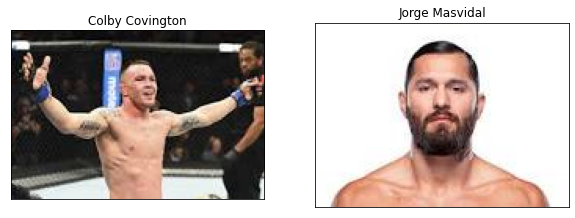

In [177]:
ufc_predict('Colby Covington','Jorge Masvidal', 'March 5, 2022', 'March 5, 2022')

The winner is...
Rafael Dos Anjos by DEC


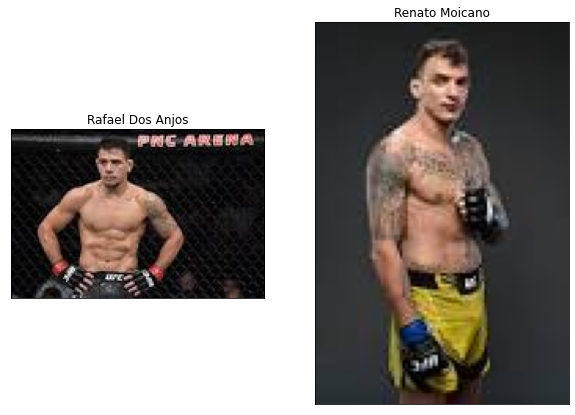

In [178]:
ufc_predict('Rafael Dos Anjos','Renato Moicano', 'March 5, 2022', 'March 5, 2022',)

In [171]:
ufc_predict('Edson Barboza','Bryce Mitchell', 'March 5, 2022', 'March 5, 2022')

The winner is...
Edson Barboza by KO/TKO


In [124]:
ufc_predict('Kevin Holland','Alex Oliveira', 'March 5, 2022', 'March 5, 2022',)

The winner is...
Kevin Holland by DEC


In [125]:
#there must be an issue with the say Spivak's name is scraped. look into this... fix needed
ufc_predict('Sergey Spivak','Greg Hardy', 'March 5, 2022', 'March 5, 2022',)

This is Sergey Spivak's UFC debut... so obviously I do not have enough data to make an educated pick. But since you are DEMANDING an outcome, hmmm... I guess I'll go with Greg Hardy.


The winner is...
Jamie Mullarkey by DEC


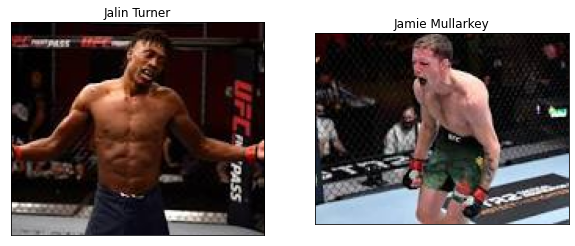

In [126]:
ufc_predict('Jalin Turner','Jamie Mullarkey', 'March 5, 2022', 'March 5, 2022',)

In [127]:
fighter_height('Yan Xiaonan')

'unknown'

In [128]:
#issue with unknown reach/height... fix needed
ufc_predict('Marina Rodriguez','Yan Xiaonan', 'March 5, 2022', 'March 5, 2022',)

The winner is...
Fighters have incomplete data on record... or maybe there is an issue with one of the fighters names... I honestly do not know what to do with this.


The winner is...
Kennedy Nzechukwu by DEC


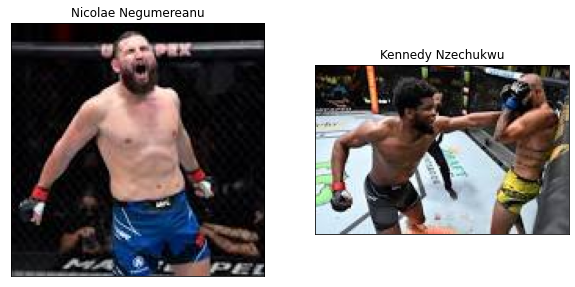

In [129]:
ufc_predict('Nicolae Negumereanu','Kennedy Nzechukwu', 'March 5, 2022', 'March 5, 2022',)

The winner is...
Mariya Agapova by DEC


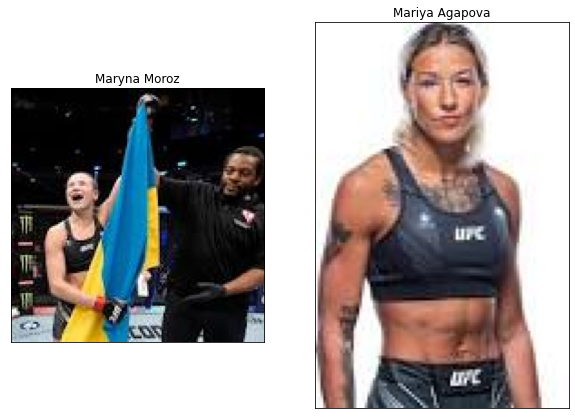

In [130]:
ufc_predict('Maryna Moroz','Mariya Agapova', 'March 5, 2022', 'March 5, 2022',)

In [131]:
ufc_predict('Umar Nurmagomedov','Brian Kelleher', 'March 5, 2022', 'March 5, 2022',)

The winner is...
Brian Kelleher by SUB


In [132]:
ufc_predict('Tim Elliott','Tagir Ulanbekov', 'March 5, 2022', 'March 5, 2022',)

The winner is...
Tagir Ulanbekov by DEC


In [133]:
#Must be an issue with michal's name in scraping
ufc_predict('Dustin Jacoby','Michał Oleksiejczuk', 'March 5, 2022', 'March 5, 2022',)

This is Michał Oleksiejczuk's UFC debut... so obviously I do not have enough data to make an educated pick. But since you are DEMANDING an outcome, hmmm... I guess I'll go with Michał Oleksiejczuk.


The winner is...
Thiago Santos by KO/TKO


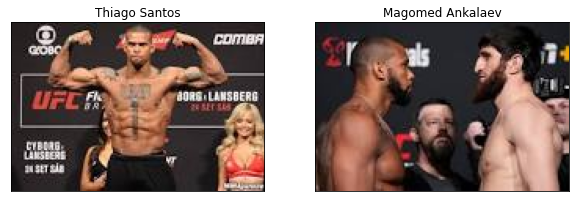

In [134]:
ufc_predict('Thiago Santos','Magomed Ankalaev', 'March 12, 2022', 'March 12, 2022',)

The winner is...
Song Yadong by KO/TKO


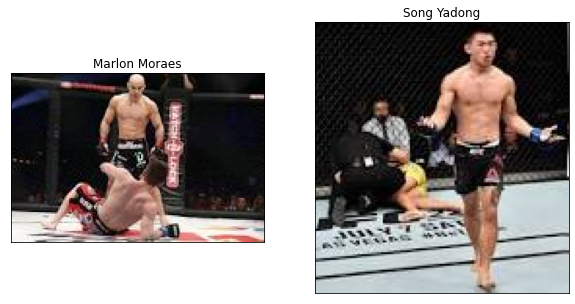

In [135]:
ufc_predict('Marlon Moraes','Song Yadong', 'March 12, 2022', 'March 12, 2022',)

The winner is...
Alex Caceres by DEC


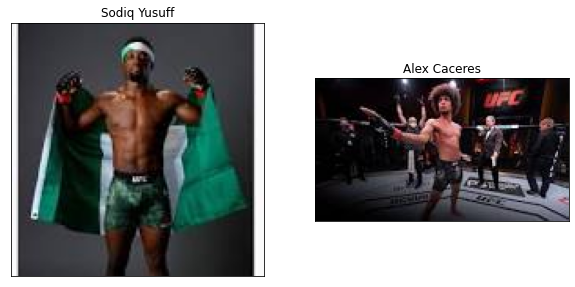

In [136]:
ufc_predict('Sodiq Yusuff','Alex Caceres', 'March 12, 2022', 'March 12, 2022',)

The winner is...
Khalil Rountree Jr. by DEC


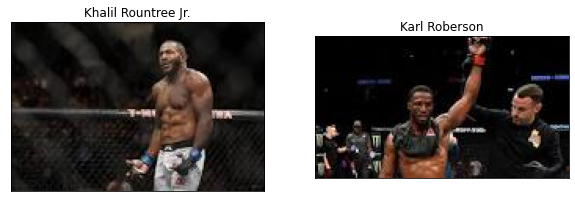

In [137]:
ufc_predict('Khalil Rountree Jr.','Karl Roberson', 'March 12, 2022', 'March 12, 2022',)

The winner is...
Drew Dober by DEC


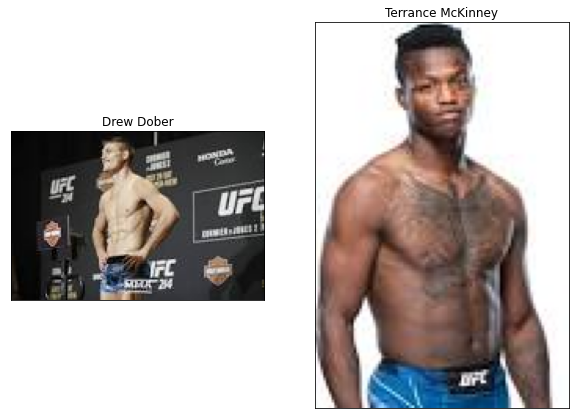

In [138]:
ufc_predict('Drew Dober','Terrance McKinney', 'March 12, 2022', 'March 12, 2022',)

The winner is...
Alex Pereira by DEC


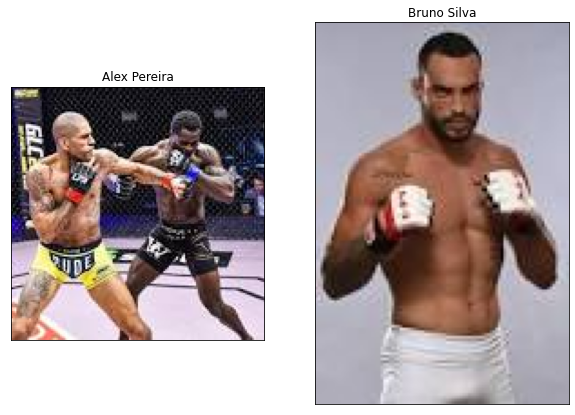

In [139]:
ufc_predict('Alex Pereira','Bruno Silva', 'March 12, 2022', 'March 12, 2022',)

In [140]:
ufc_predict('Matthew Semelsberger','AJ Fletcher', 'March 12, 2022', 'March 12, 2022',)

The winner is...
Fighters have incomplete data on record... or maybe there is an issue with one of the fighters names... I honestly do not know what to do with this.


The winner is...
JJ Aldrich by DEC


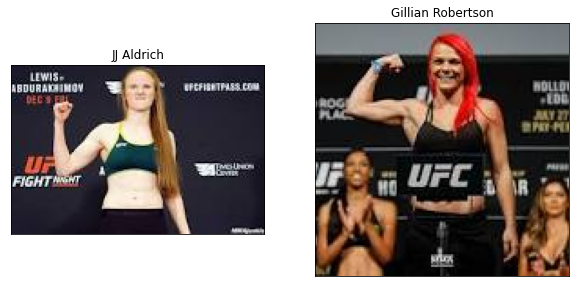

In [141]:
ufc_predict('JJ Aldrich','Gillian Robertson', 'March 12, 2022', 'March 12, 2022',)

The winner is...
Trevin Jones by DEC


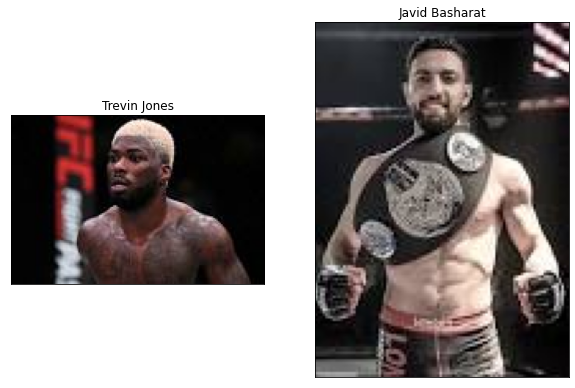

In [142]:
ufc_predict('Trevin Jones','Javid Basharat', 'March 12, 2022', 'March 12, 2022',)

In [143]:
ufc_predict('Damon Jackson','Kamuela Kirk', 'March 12, 2022', 'March 12, 2022',)

The winner is...
Damon Jackson by DEC
That picture is not in the database somehow...


The winner is...
Miranda Maverick by DEC


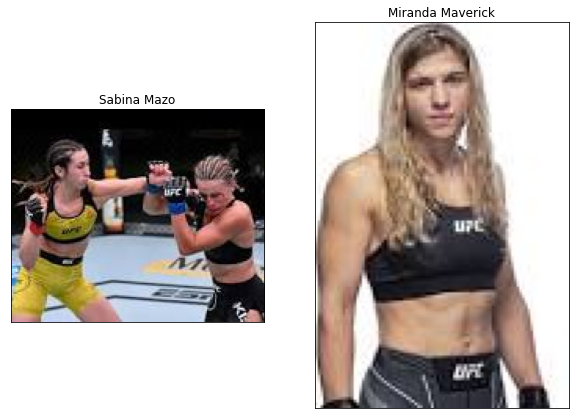

In [144]:
ufc_predict('Sabina Mazo','Miranda Maverick', 'March 12, 2022', 'March 12, 2022',)

The winner is...
Dalcha Lungiambula by DEC


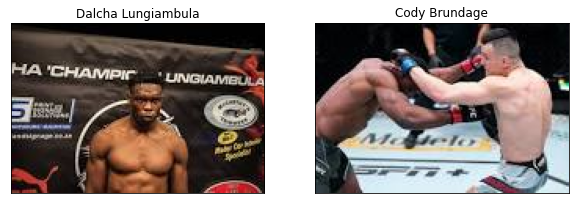

In [145]:
ufc_predict('Dalcha Lungiambula','Cody Brundage', 'March 12, 2022', 'March 12, 2022',)

The winner is...
Kris Moutinho by DEC


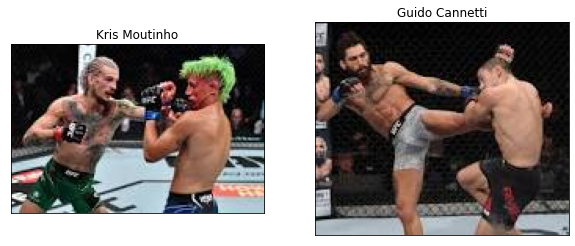

In [146]:
ufc_predict('Kris Moutinho','Guido Cannetti', 'March 12, 2022', 'March 12, 2022',)

The winner is...
Azamat Murzakanov by DEC


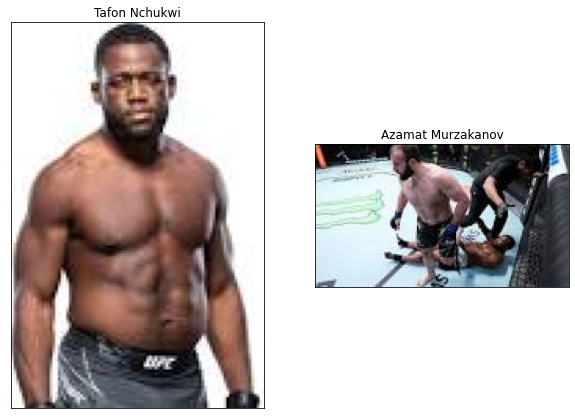

In [147]:
ufc_predict('Tafon Nchukwi','Azamat Murzakanov', 'March 12, 2022', 'March 12, 2022',)

The winner is...
Gabriel Benitez by KO/TKO


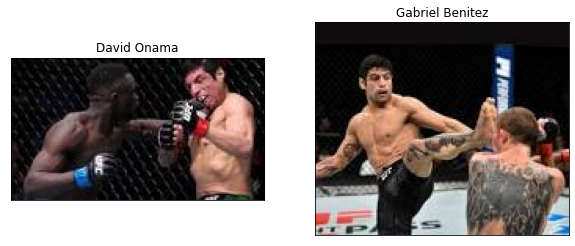

In [148]:
ufc_predict(ufc_fights['fighter'][i],ufc_fights['opponent'][i],ufc_fights['date'][i],ufc_fights['date'][i])

The winner is...
Tom Aspinall by DEC


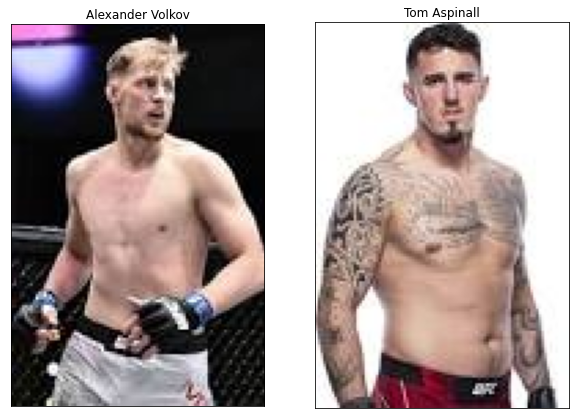

In [149]:
ufc_predict('Alexander Volkov','Tom Aspinall','March 19, 2022','March 19, 2022')

The winner is...
Dan Hooker by DEC


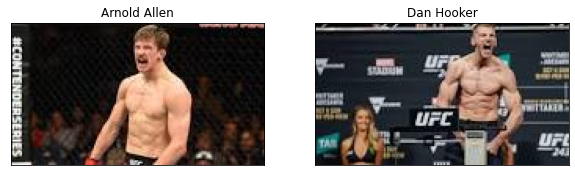

In [150]:
ufc_predict('Arnold Allen','Dan Hooker','March 19, 2022','March 19, 2022')

In [151]:
ufc_predict('Paddy Pimblett','Rodrigo Vargas','March 19, 2022','March 19, 2022')

This is Rodrigo Vargas's UFC debut... so obviously I do not have enough data to make an educated pick. But since you are DEMANDING an outcome, hmmm... I guess I'll go with Rodrigo Vargas.


The winner is...
Takashi Sato by DEC


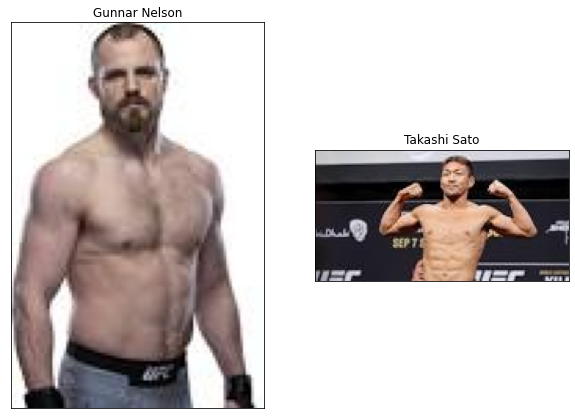

In [152]:
ufc_predict('Gunnar Nelson','Takashi Sato','March 19, 2022','March 19, 2022')

The winner is...
Luana Carolina by DEC


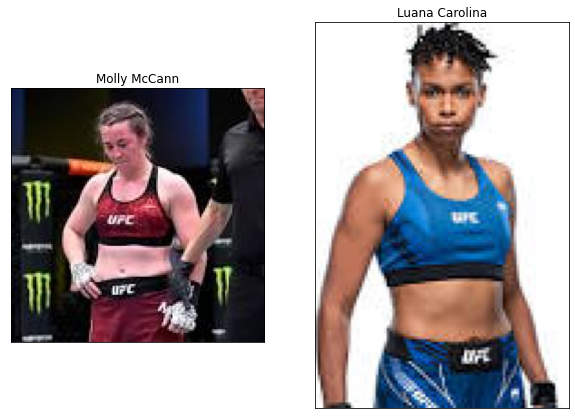

In [153]:
ufc_predict('Molly McCann','Luana Carolina','March 19, 2022','March 19, 2022')

The winner is...
Ilia Topuria by DEC


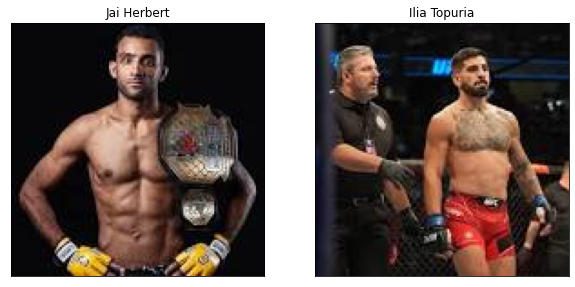

In [154]:
ufc_predict('Jai Herbert','Ilia Topuria','March 19, 2022','March 19, 2022')

The winner is...
Mike Grundy by DEC


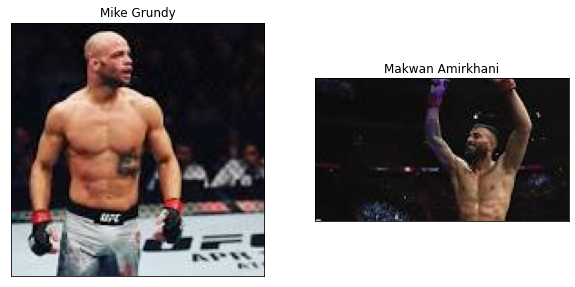

In [155]:
ufc_predict('Mike Grundy', 'Makwan Amirkhani', 'March 19, 2022', 'March 19, 2022')

In [156]:
ufc_predict('Shamil Abdurakhimov', 'Sergei Pavlovich', 'March 19, 2022', 'March 19, 2022')

The winner is...
Shamil Abdurakhimov by KO/TKO


In [157]:
ufc_predict('Nikita Krylov', 'Paul Craig', 'March 19, 2022', 'March 19, 2022')

The winner is...
Paul Craig by DEC


The winner is...
Timur Valiev by DEC


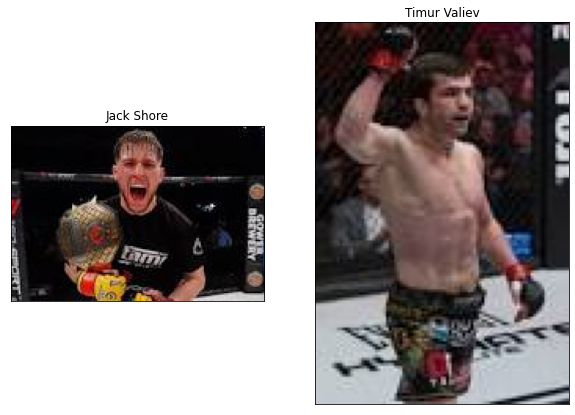

In [158]:
ufc_predict('Jack Shore', 'Timur Valiev', 'March 19, 2022', 'March 19, 2022')

The winner is...
Elise Reed by DEC


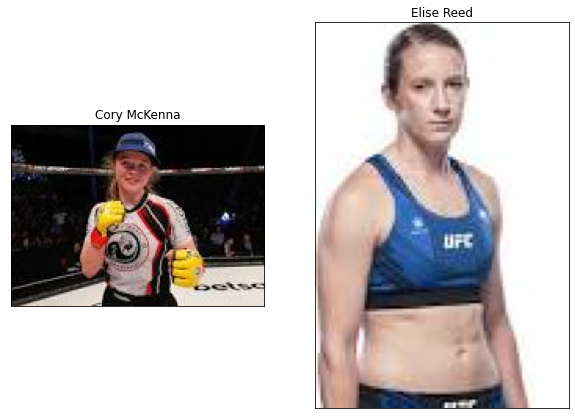

In [159]:
ufc_predict('Cory McKenna', 'Elise Reed', 'March 19, 2022', 'March 19, 2022')

In [160]:
ufc_predict('Nathaniel Wood', 'Vince Morales', 'March 19, 2022', 'March 19, 2022')

The winner is...
Vince Morales by DEC


In [161]:
ufc_predict('Muhammad Mokaev', 'Cody Durden', 'March 19, 2022', 'March 19, 2022')

This is Muhammad Mokaev's UFC debut... so obviously I do not have enough data to make an educated pick. But since you are DEMANDING an outcome, hmmm... I guess I'll go with Muhammad Mokaev.


In [162]:
ufc_predict('Cody Garbrandt','Raphael Assuncao', 'March 5, 2022', 'March 5, 2022')

The winner is...
Raphael Assuncao by DEC


The winner is...
Daniel Cormier


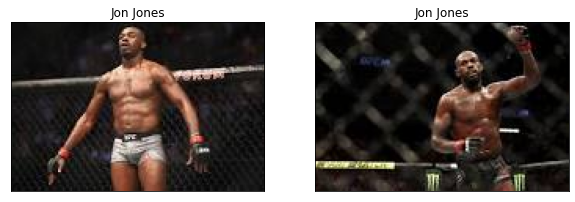

In [175]:
ufc_predict('Jon Jones','Jon Jones', 'March 5, 2022', 'March 5, 2022')

In [179]:
ufc_predict('Francis Ngannou','Francis Ngannou', 'March 5, 2022', 'March 5, 2022')

The winner is...
Francis Ngannou by DEC


In [182]:
ufc_predict('Randy Couture','Francis Ngannou', 'March 5, 2012', 'March 5, 2022')

The winner is...
Randy Couture by KO/TKO
That picture is not in the database somehow...


The winner is...
Roy Nelson by DEC


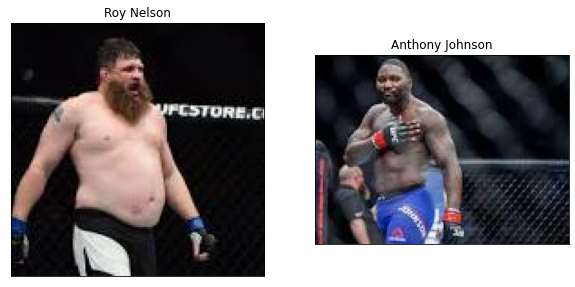

In [181]:
ufc_predict('Roy Nelson','Anthony Johnson', 'March 5, 2012', 'March 5, 2022')